# 객체 검출 (Object Detection)
이 코드에서는 LiDAR 포인트 클라우드 및 카메라 이미지를 활용한 객체 검출 방법에 대해 학습하고, 다양한 객체 검출 알고리즘을 구현합니다.
## 학습 목표
- 객체 검출의 기본 개념 및 접근 방식 이해
- 포인트 클라우드 기반 클러스터링 구현
- 2D/3D 바운딩 박스 생성 및 처리 방법 학습
- 객체 분류를 위한 기하학적 특징 추출
- 딥러닝 기반 객체 검출 방법 이해
- 센서 융합 기반 객체 검출 구현

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import sys
import time
from glob import glob
from PIL import Image
from sklearn.cluster import DBSCAN
from scipy.spatial import ConvexHull

# 딥러닝 모델 관련 라이브러리
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet18

# 시각화 설정
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12, 8)
plt.style.use('ggplot')

# 한글 폰트 설정 (필요한 경우)
try:
    import platform
    if platform.system() == 'Windows':
        # Windows
        plt.rcParams['font.family'] = 'Malgun Gothic'
    elif platform.system() == 'Darwin':
        # macOS
        plt.rcParams['font.family'] = 'AppleGothic'
    else:
        # Linux
        plt.rcParams['font.family'] = 'NanumGothic'
    
    # minus 기호 표시 문제 해결
    matplotlib.rcParams['axes.unicode_minus'] = False
    print("한글 폰트 설정 완료")
except:
    print("한글 폰트 설정 실패. 영문으로 표시합니다.")

한글 폰트 설정 완료


## 1. 데이터 로드 함수 정의


In [3]:
def load_point_cloud(bin_path):
    """
    KITTI bin 형식의 포인트 클라우드 파일 로드
    
    Args:
        bin_path (str): bin 파일 경로
        
    Returns:
        numpy.ndarray: 포인트 클라우드 [N, 4] (x, y, z, intensity)
    """
    # 이진 파일에서 4xN float 배열로 읽기
    points = np.fromfile(bin_path, dtype=np.float32).reshape(-1, 4)
    return points

def load_image(img_path):
    """
    이미지 파일 로드
    
    Args:
        img_path (str): 이미지 파일 경로
        
    Returns:
        numpy.ndarray: RGB 이미지
    """
    img = cv2.imread(img_path)
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # BGR -> RGB
    return img

def load_calib_data(calib_filepath):
    """
    Load and parse calibration data from KITTI calibration file.
    
    Args:
        calib_filepath (str): Path to the calibration file
        
    Returns:
        dict: Dictionary containing calibration matrices
    """
    calibration = {}
    
    try:
        with open(calib_filepath, 'r') as f:
            lines = f.readlines()
            
            for line in lines:
                line = line.strip()
                if not line or line.startswith('#'):  # 빈 줄이나 주석 건너뛰기
                    continue
                    
                if ':' in line:
                    key, value = line.split(':', 1)  # 최대 1번만 분할
                    key = key.strip()
                    values = [float(x) for x in value.strip().split()]
                    
                    if key == 'R0_rect':
                        calibration[key] = np.reshape(values, (3, 3))
                    elif key in ['Tr_velo_to_cam', 'Tr_imu_to_velo']:
                        # Convert 3x4 matrix to 4x4 by adding [0,0,0,1] as the last row
                        matrix = np.reshape(values, (3, 4))
                        matrix_4x4 = np.vstack((matrix, [0, 0, 0, 1]))
                        calibration[key] = matrix_4x4
                    elif key in ['P0', 'P1', 'P2', 'P3']:
                        calibration[key] = np.reshape(values, (3, 4))
                else:
                    # ':' 구분자가 없는 경우, 다른 형식 처리
                    parts = line.split()
                    if len(parts) > 1:  # 최소 키와 값이 있어야 함
                        key = parts[0]
                        values = [float(x) for x in parts[1:]]
                        # 적절한 형태로 변환 (여기서는 단순 벡터로)
                        calibration[key] = np.array(values)
    except Exception as e:
        print(f"캘리브레이션 파일 로드 중 오류: {e}")
        # 예시 캘리브레이션 데이터로 대체
        calibration = {
            'P2': np.array([
                [721.5377, 0.0, 609.5593, 44.85728],
                [0.0, 721.5377, 172.854, 0.2163791],
                [0.0, 0.0, 1.0, 0.002745884]
            ]),
            'R0_rect': np.eye(3),
            'Tr_velo_to_cam': np.array([
                [7.533745e-03, -9.999714e-01, -6.166020e-04, -4.069766e-03],
                [1.480249e-02, 7.280733e-04, -9.998902e-01, -7.631618e-02],
                [9.998621e-01, 7.523790e-03, 1.480755e-02, -2.717806e-01],
                [0.0, 0.0, 0.0, 1.0]
            ])
        }
    
    return calibration

## 2. 데이터 로드 (Example)

In [4]:
# 데이터 경로 설정
data_dir = '/home/shbyun/KITTI/ObjectDetection/'
point_cloud_dir = os.path.join(data_dir, 'data_object_velodyne/training', 'velodyne')
image_dir = os.path.join(data_dir, 'data_object_image_2/training', 'image_2')
calib_dir = os.path.join(data_dir, 'data_object_calib/training', 'calib')

# 샘플 프레임 ID
frame_id = '000010'

# 파일 경로 생성
point_cloud_path = os.path.join(point_cloud_dir, f'{frame_id}.bin')
image_path = os.path.join(image_dir, f'{frame_id}.png')
calib_path = os.path.join(calib_dir, f'{frame_id}.txt')

# 데이터 로드 (실제 파일이 없는 경우를 위한 에러 처리 추가)
try:
    points = load_point_cloud(point_cloud_path)
    image = load_image(image_path)
    calib_data = load_calib_data(calib_path)
    print(f"데이터 로드 완료: 포인트={points.shape}, 이미지={image.shape if image is not None else 'None'}")
except Exception as e:
    print(f"데이터 로드 중 오류 발생: {e}")
    print("샘플 데이터를 사용합니다...")
    
    # 샘플 포인트 클라우드 생성
    num_points = 20000
    x = np.random.uniform(-30, 30, num_points)
    y = np.random.uniform(-30, 30, num_points)
    z = np.random.uniform(-2, 5, num_points)
    intensity = np.random.uniform(0, 1, num_points)
    points = np.column_stack((x, y, z, intensity))
    
    # 지면 점 생성
    ground_idx = np.random.choice(num_points, int(num_points*0.6), replace=False)
    points[ground_idx, 2] = -1.7 + np.random.normal(0, 0.1, len(ground_idx))
    
    # 간단한 이미지 생성
    image = np.zeros((375, 1242, 3), dtype=np.uint8)
    cv2.rectangle(image, (300, 200), (500, 300), (0, 255, 0), 3)  # 샘플 객체
    
    # 샘플 캘리브레이션 데이터
    calib_data = {
        'P2': np.array([
            [721.5377, 0.0, 609.5593, 44.85728],
            [0.0, 721.5377, 172.854, 0.2163791],
            [0.0, 0.0, 1.0, 0.002745884]
        ]),
        'R0_rect': np.eye(3),
        'Tr_velo_to_cam': np.array([
            [7.533745e-03, -9.999714e-01, -6.166020e-04, -4.069766e-03],
            [1.480249e-02, 7.280733e-04, -9.998902e-01, -7.631618e-02],
            [9.998621e-01, 7.523790e-03, 1.480755e-02, -2.717806e-01],
            [0.0, 0.0, 0.0, 1.0]
        ])
    }

데이터 로드 완료: 포인트=(115875, 4), 이미지=(375, 1242, 3)


## 3. 노면 제거 (Ground Removal)

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.


전체 포인트 수: 115875
노면 포인트 수: 62243
비노면 포인트 수: 53632
노면 방정식: 0.0077x + -0.0085y + -0.9999z + -1.6718 = 0


findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

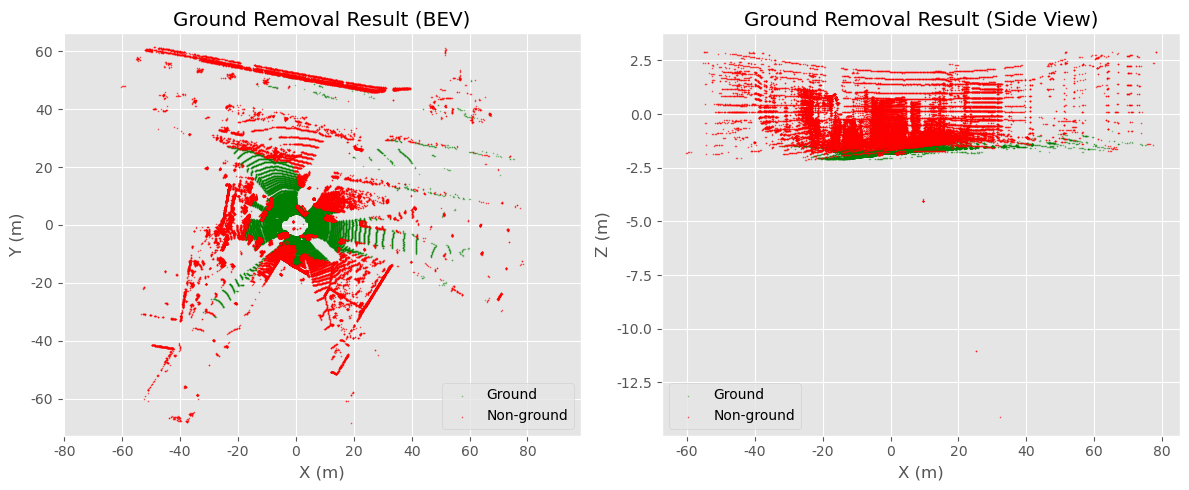

In [5]:
def ransac_ground_detection(points, distance_thresh=0.15, max_iterations=100, return_model=False):
    """
    RANSAC을 사용하여 지면 포인트 검출
    
    Args:
        points (numpy.ndarray): 포인트 클라우드 [N, 3+] (x, y, z, ...)
        distance_thresh (float): 지면 포인트로 판단하는 거리 임계값
        max_iterations (int): RANSAC 최대 반복 횟수
        return_model (bool): 모델 파라미터 반환 여부
        
    Returns:
        numpy.ndarray: 지면 포인트 마스크 (boolean)
        dict (optional): 지면 모델 파라미터 (return_model=True인 경우)
    """
    # 바닥면 감지를 위한 RANSAC 알고리즘
    # x, y 좌표를 특징(features)으로, z 좌표를 타겟(target)으로 사용
    X = points[:, :2]
    y = points[:, 2]
    
    # 최적 모델 초기화
    best_inliers = None
    best_equation = None
    max_inliers = 0
    
    for _ in range(max_iterations):
        # 무작위로 3개 포인트 선택
        sample_indices = np.random.choice(len(X), 3, replace=False)
        sample_points = np.hstack([X[sample_indices], y[sample_indices].reshape(-1, 1)])
        
        try:
            # 평면 방정식 계수 구하기: ax + by + cz + d = 0
            # 여기서는 c = -1로 표준화 (z = ax + by + d)
            x1, y1, z1 = sample_points[0]
            x2, y2, z2 = sample_points[1]
            x3, y3, z3 = sample_points[2]
            
            # 평면 결정을 위한 행렬 방정식 풀기
            a = np.array([
                [x1, y1, 1],
                [x2, y2, 1],
                [x3, y3, 1]
            ])
            b = np.array([z1, z2, z3])
            
            # 행렬 방정식 ax=b 풀기 
            plane = np.linalg.solve(a, b)
            a, b, d = plane
            c = -1  # z = ax + by + d 형태로 표준화
            
            # 모든 포인트에 대해 평면과의 거리 계산
            distances = np.abs(X[:, 0]*a + X[:, 1]*b + y*c + d) / np.sqrt(a**2 + b**2 + c**2)
            
            # 임계값 이내의 포인트를 인라이어로 판단
            inliers = distances < distance_thresh
            num_inliers = np.sum(inliers)
            
            # 더 많은 인라이어를 가진 모델 발견 시 업데이트
            if num_inliers > max_inliers:
                max_inliers = num_inliers
                best_inliers = inliers
                best_equation = (a, b, c, d)
        except:
            # 행렬 방정식 풀이 오류 시 다음 반복으로
            continue
    
    if best_inliers is None:
        # RANSAC 실패 시 빈 마스크 반환
        inlier_mask = np.zeros(len(points), dtype=bool)
        model = {'normal': np.array([0, 0, 1]), 'intercept': 0} if return_model else None
    else:
        inlier_mask = best_inliers
        
        if return_model:
            a, b, c, d = best_equation
            # 법선 벡터 (a, b, c)
            normal = np.array([a, b, c])
            # 정규화
            normal = normal / np.linalg.norm(normal)
            model = {'normal': normal, 'intercept': d}
        else:
            model = None
    
    if return_model:
        return inlier_mask, model
    else:
        return inlier_mask

def remove_ground_points(points, ground_mask):
    """
    포인트 클라우드에서 노면 포인트 제거
    
    Args:
        points (numpy.ndarray): 포인트 클라우드 [N, 3+] (x, y, z, ...)
        ground_mask (numpy.ndarray): 노면 포인트 마스크 (boolean)
        
    Returns:
        numpy.ndarray: 노면을 제외한 포인트 클라우드
    """
    return points[~ground_mask]

# 노면 제거 수행
ground_mask, ground_model = ransac_ground_detection(points, distance_thresh=0.2, max_iterations=100, return_model=True)
non_ground_points = remove_ground_points(points, ground_mask)

print(f"전체 포인트 수: {len(points)}")
print(f"노면 포인트 수: {np.sum(ground_mask)}")
print(f"비노면 포인트 수: {len(non_ground_points)}")
print(f"노면 방정식: {ground_model['normal'][0]:.4f}x + {ground_model['normal'][1]:.4f}y + {ground_model['normal'][2]:.4f}z + {ground_model['intercept']:.4f} = 0")

# 노면 제거 결과 시각화
def visualize_ground_removal(points, ground_mask):
    """노면 제거 결과 시각화"""
    plt.figure(figsize=(12, 5))
    
    # Bird's Eye View (BEV)
    plt.subplot(121)
    plt.scatter(points[ground_mask, 0], points[ground_mask, 1], c='green', s=0.5, alpha=0.3, label='Ground')
    plt.scatter(points[~ground_mask, 0], points[~ground_mask, 1], c='red', s=0.5, alpha=0.5, label='Non-ground')
    plt.title('Ground Removal Result (BEV)')
    plt.xlabel('X (m)')
    plt.ylabel('Y (m)')
    plt.axis('equal')
    plt.legend()
    plt.grid(True)
    
    # 측면 뷰
    plt.subplot(122)
    plt.scatter(points[ground_mask, 0], points[ground_mask, 2], c='green', s=0.5, alpha=0.3, label='Ground')
    plt.scatter(points[~ground_mask, 0], points[~ground_mask, 2], c='red', s=0.5, alpha=0.5, label='Non-ground')
    plt.title('Ground Removal Result (Side View)')
    plt.xlabel('X (m)')
    plt.ylabel('Z (m)')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# 노면 제거 결과 시각화 실행
visualize_ground_removal(points, ground_mask)

## 4. 클러스터링 기반 객체 검출


검출된 클러스터 수: 229
클러스터 0: 23 포인트
클러스터 1: 19 포인트
클러스터 2: 19 포인트
클러스터 3: 17 포인트
클러스터 4: 56 포인트


findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

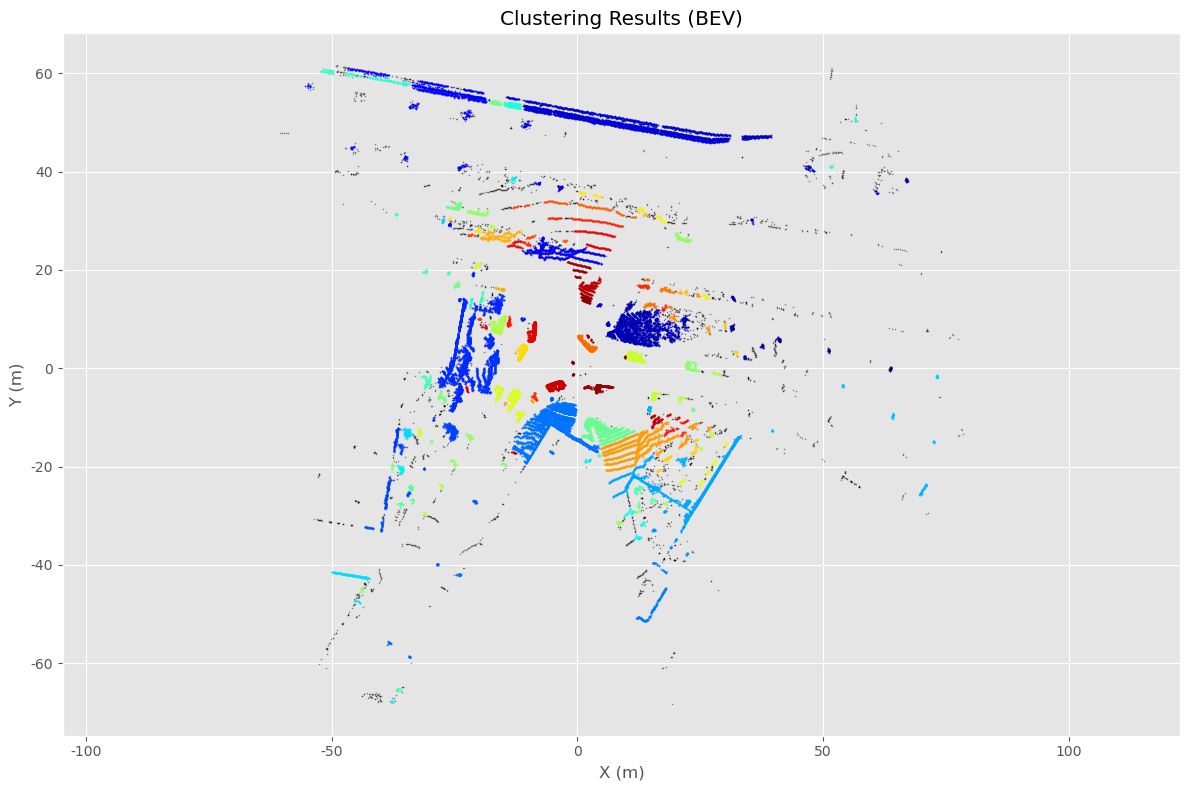

In [6]:
def euclidean_clustering(points, eps=0.5, min_points=10, max_points=10000):
    """
    DBSCAN 알고리즘을 사용한 유클리디안 클러스터링
    
    Args:
        points (numpy.ndarray): 포인트 클라우드 [N, 3+] (x, y, z, ...)
        eps (float): DBSCAN 클러스터링 반경
        min_points (int): 클러스터를 형성하기 위한 최소 포인트 수
        max_points (int): 클러스터의 최대 포인트 수 (노이즈 필터링)
        
    Returns:
        list: 클러스터 리스트 (각 클러스터는 포인트 배열)
        numpy.ndarray: 각 포인트의 클러스터 레이블 (-1은 노이즈)
    """
    # DBSCAN 클러스터링 수행 (XY 평면에서만)
    db = DBSCAN(eps=eps, min_samples=min_points, n_jobs=-1).fit(points[:, :2])
    labels = db.labels_
    
    # 각 클러스터 추출
    unique_labels = set(labels)
    unique_labels.discard(-1)  # 노이즈 레이블 제외
    
    clusters = []
    for label in unique_labels:
        cluster_points = points[labels == label]
        
        # 너무 큰 클러스터는 필터링 (노면 잔여물일 수 있음)
        if len(cluster_points) <= max_points:
            clusters.append(cluster_points)
    
    return clusters, labels

# 클러스터링 수행
clusters, labels = euclidean_clustering(non_ground_points, eps=0.5, min_points=10, max_points=5000)
print(f"검출된 클러스터 수: {len(clusters)}")
for i, cluster in enumerate(clusters[:5]):  # 처음 5개만 출력
    print(f"클러스터 {i}: {len(cluster)} 포인트")

# 클러스터링 결과 시각화
def visualize_clusters(points, labels):
    """클러스터링 결과 시각화"""
    # 고유 레이블 (노이즈 제외)
    unique_labels = list(set(labels))
    if -1 in unique_labels:
        unique_labels.remove(-1)
    
    # 색상 맵 생성
    colors = plt.cm.jet(np.linspace(0, 1, len(unique_labels)))
    
    plt.figure(figsize=(12, 8))
    
    # 노이즈 포인트 (레이블이 -1)
    noise_points = points[labels == -1]
    plt.scatter(noise_points[:, 0], noise_points[:, 1], c='black', s=0.5, alpha=0.3, label='Noise')
    
    # 각 클러스터 그리기
    for i, label in enumerate(unique_labels):
        cluster_points = points[labels == label]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], 
                   c=[colors[i]], s=0.8, alpha=0.6, label=f'Cluster {label}')
    
    plt.title('Clustering Results (BEV)')
    plt.xlabel('X (m)')
    plt.ylabel('Y (m)')
    plt.axis('equal')
    plt.grid(True)
    
    # 객체가 너무 많으면 범례 생략
    if len(unique_labels) < 20:
        plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1))
    
    plt.tight_layout()
    plt.show()

# 클러스터링 결과 시각화 실행
visualize_clusters(non_ground_points, labels)


## 5. 바운딩 박스 생성 및 객체 분류

분류된 객체 수: 225
객체 0: 클래스=unknown, 신뢰도=0.50, 크기=[2.70039616 0.66394027 0.14521375]
객체 1: 클래스=unknown, 신뢰도=0.50, 크기=[0.96252541 0.69925114 0.54130798]
객체 2: 클래스=unknown, 신뢰도=0.50, 크기=[2.86239483 0.89165686 0.26621068]
객체 3: 클래스=unknown, 신뢰도=0.50, 크기=[1.11346662 0.6288196  0.36290775]
객체 4: 클래스=unknown, 신뢰도=0.50, 크기=[2.77384689 1.0568849  0.79707247]


findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

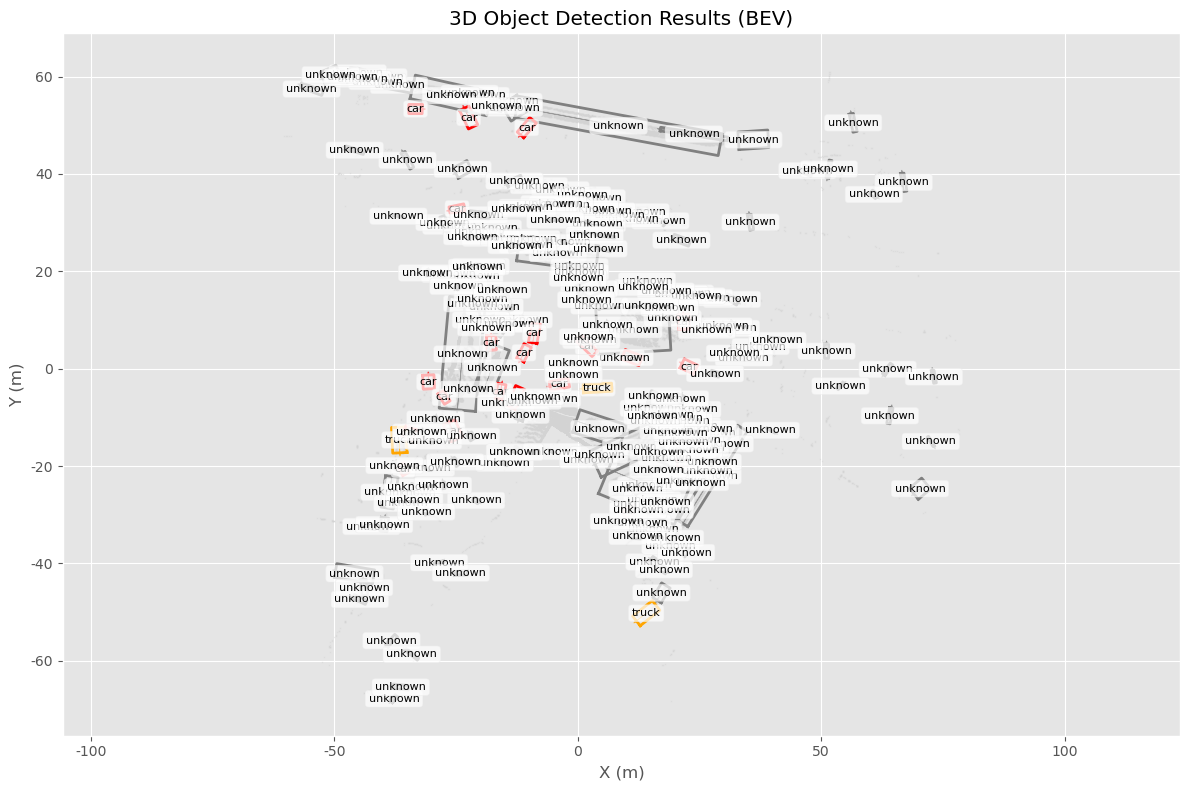

In [8]:
def visualize_detection_results(points, objects):
    """객체 검출 결과 시각화"""
    plt.figure(figsize=(12, 8))
    
    # 포인트 클라우드 (회색으로 배경처럼 표시)
    plt.scatter(points[:, 0], points[:, 1], c='lightgray', s=0.5, alpha=0.3)
    
    # 클래스별 색상 정의
    class_colors = {
        'car': 'red',
        'truck': 'orange',
        'pedestrian': 'green',
        'cyclist': 'blue',
        'pole': 'purple',
        'unknown': 'gray'
    }
    
    # 각 객체에 대한 바운딩 박스 그리기
    for obj in objects:
        # 객체 클래스 및 중심점
        cls = obj['class']
        center = obj['center']
        
        # 클래스에 따른 색상 선택
        color = class_colors.get(cls, 'gray')
        
        # 회전 각도
        yaw = obj['yaw']
        
        # 바운딩 박스 크기
        length, width, height = obj['dimensions']
        
        # 2D 바운딩 박스 생성 (BEV에서 나타내기 위해 X-Y 평면)
        # 회전을 고려한 코너 계산
        cos_yaw = np.cos(yaw)
        sin_yaw = np.sin(yaw)
        
        # 바운딩 박스의 네 코너 (회전 고려)
        corners = np.array([
            [center[0] + cos_yaw * length / 2 - sin_yaw * width / 2,
             center[1] + sin_yaw * length / 2 + cos_yaw * width / 2],
            [center[0] + cos_yaw * length / 2 + sin_yaw * width / 2,
             center[1] + sin_yaw * length / 2 - cos_yaw * width / 2],
            [center[0] - cos_yaw * length / 2 + sin_yaw * width / 2,
             center[1] - sin_yaw * length / 2 - cos_yaw * width / 2],
            [center[0] - cos_yaw * length / 2 - sin_yaw * width / 2,
             center[1] - sin_yaw * length / 2 + cos_yaw * width / 2],
            [center[0] + cos_yaw * length / 2 - sin_yaw * width / 2,
             center[1] + sin_yaw * length / 2 + cos_yaw * width / 2]  # 첫 번째 포인트 반복하여 폐곡선 생성
        ])
        
        # 바운딩 박스 그리기
        plt.plot(corners[:, 0], corners[:, 1], color=color, linewidth=2)
        
        # 주행 방향 화살표 그리기 (길이 방향)
        direction = np.array([cos_yaw, sin_yaw]) * length / 2
        plt.arrow(center[0], center[1], direction[0], direction[1], 
                  head_width=0.5, head_length=0.7, fc=color, ec=color, alpha=0.7)
        
        # 객체 레이블 표시
        plt.text(center[0], center[1], f"{cls}", 
                fontsize=8, ha='center', va='center', 
                bbox=dict(facecolor='white', alpha=0.7, boxstyle='round'))
    
    plt.title('3D Object Detection Results (BEV)')
    plt.xlabel('X (m)')
    plt.ylabel('Y (m)')
    plt.axis('equal')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
def compute_oriented_bounding_box(points):
    """
    포인트 클라우드에 대한 방향성 바운딩 박스 계산
    
    Args:
        points (numpy.ndarray): 클러스터 포인트 [N, 3+] (x, y, z, ...)
        
    Returns:
        dict: 바운딩 박스 정보 (center, dimensions, rotation_matrix)
    """
    # 중심점 계산
    center = np.mean(points[:, :3], axis=0)
    
    # 중심으로 이동
    centered_points = points[:, :3] - center
    
    # PCA를 통한 주방향 계산
    covariance_matrix = np.cov(centered_points.T)
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
    
    # 고유값 내림차순 정렬
    idx = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    # 회전 행렬 생성
    rotation_matrix = eigenvectors
    
    # 회전 좌표계에서 바운딩 박스 계산
    rotated_points = centered_points @ rotation_matrix
    min_bounds = np.min(rotated_points, axis=0)
    max_bounds = np.max(rotated_points, axis=0)
    
    # 바운딩 박스 크기
    dimensions = max_bounds - min_bounds
    
    # Yaw 각도 계산 (XY 평면 기준)
    yaw = np.arctan2(rotation_matrix[1, 0], rotation_matrix[0, 0])
    
    return {
        'center': center,
        'dimensions': dimensions,
        'rotation_matrix': rotation_matrix,
        'yaw': yaw,
        'min_bounds': min_bounds,
        'max_bounds': max_bounds
    }

def classify_object(bbox, features):
    """
    바운딩 박스와 특징을 기반으로 객체 분류
    
    Args:
        bbox (dict): 바운딩 박스 정보
        features (dict): 추가 특징 정보
        
    Returns:
        str: 객체 클래스
        float: 신뢰도
    """
    # 분류를 위한 기하학적 특징 추출
    length, width, height = bbox['dimensions']
    volume = length * width * height
    
    # 단순한 규칙 기반 분류
    confidence = 0.7  # 기본 신뢰도
    
    # 차량 (length > width, height < length)
    if (1.5 < length < 7.0) and (1.3 < width < 3.0) and (1.0 < height < 3.0):
        if length > 5.0 or height > 2.5:
            obj_class = 'truck'
        else:
            obj_class = 'car'
    
    # 보행자 (height > width, height > length)
    elif (0.4 < length < 1.0) and (0.4 < width < 1.0) and (1.4 < height < 2.2):
        obj_class = 'pedestrian'
    
    # 자전거/이륜차 (length > width)
    elif (1.0 < length < 2.5) and (0.4 < width < 1.0) and (1.0 < height < 2.0):
        obj_class = 'cyclist'
    
    # 기타 객체 - 표지판, 전봇대 등 (height >> width, height >> length)
    elif height > 3*width and height > 3*length and height > 2.0:
        obj_class = 'pole'
    
    # 알 수 없는 객체
    else:
        obj_class = 'unknown'
        confidence = 0.5  # 낮은 신뢰도
    
    return obj_class, confidence

def extract_geometric_features(cluster_points):
    """
    포인트 클러스터에서 기하학적 특징 추출
    
    Args:
        cluster_points (numpy.ndarray): 클러스터 포인트 [N, 3+] (x, y, z, ...)
        
    Returns:
        dict: 특징 정보
    """
    # 포인트 수
    num_points = len(cluster_points)
    
    # 통계적 특성
    mean = np.mean(cluster_points[:, :3], axis=0)
    std = np.std(cluster_points[:, :3], axis=0)
    min_pt = np.min(cluster_points[:, :3], axis=0)
    max_pt = np.max(cluster_points[:, :3], axis=0)
    
    # 크기 계산
    size = max_pt - min_pt
    
    # 강도 특성 (있는 경우)
    if cluster_points.shape[1] >= 4:
        intensity_mean = np.mean(cluster_points[:, 3])
        intensity_std = np.std(cluster_points[:, 3])
    else:
        intensity_mean = intensity_std = 0
    
    try:
        # 2D XY 평면에서의 Convex Hull 계산
        hull = ConvexHull(cluster_points[:, :2])
        hull_area = hull.volume  # 2D에서 volume은 면적을 의미
        hull_perimeter = hull.area  # 2D에서 area는 둘레를 의미
    except:
        hull_area = hull_perimeter = 0
    
    # 특징 사전 반환
    return {
        'num_points': num_points,
        'mean': mean,
        'std': std,
        'size': size,
        'intensity_mean': intensity_mean,
        'intensity_std': intensity_std,
        'hull_area': hull_area,
        'hull_perimeter': hull_perimeter
    }

# 각 클러스터에 대한 바운딩 박스 생성 및 객체 분류
object_results = []

for i, cluster in enumerate(clusters):
    # 최소 포인트 수 체크
    if len(cluster) < 10:
        continue
    
    # 바운딩 박스 계산
    bbox = compute_oriented_bounding_box(cluster)
    
    # 특징 추출
    features = extract_geometric_features(cluster)
    
    # 객체 분류
    obj_class, confidence = classify_object(bbox, features)
    
    # 객체 정보 저장
    object_info = {
        'id': i,
        'class': obj_class,
        'confidence': confidence,
        'center': bbox['center'],
        'dimensions': bbox['dimensions'],
        'yaw': bbox['yaw'],
        'bbox': bbox,
        'features': features,
        'points': cluster
    }
    
    object_results.append(object_info)

print(f"분류된 객체 수: {len(object_results)}")
for i, obj in enumerate(object_results[:5]):  # 처음 5개만 출력
    print(f"객체 {i}: 클래스={obj['class']}, 신뢰도={obj['confidence']:.2f}, 크기={obj['dimensions']}")

# 객체 검출 결과 시각화
visualize_detection_results(non_ground_points, object_results)

## 6. CenterPoint 기반 딥러닝 객체 검출 (BEV 기반)

CenterPoint 검출 객체 수: 225
객체 0: 클래스=unknown, 신뢰도=0.60, 중심점=[63.77238696  0.08673358  1.16021524]
객체 1: 클래스=unknown, 신뢰도=0.60, 중심점=[34.54360287  2.62060531  1.12851322]
객체 2: 클래스=unknown, 신뢰도=0.60, 중심점=[51.00680947  3.38589789  0.41621803]


findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

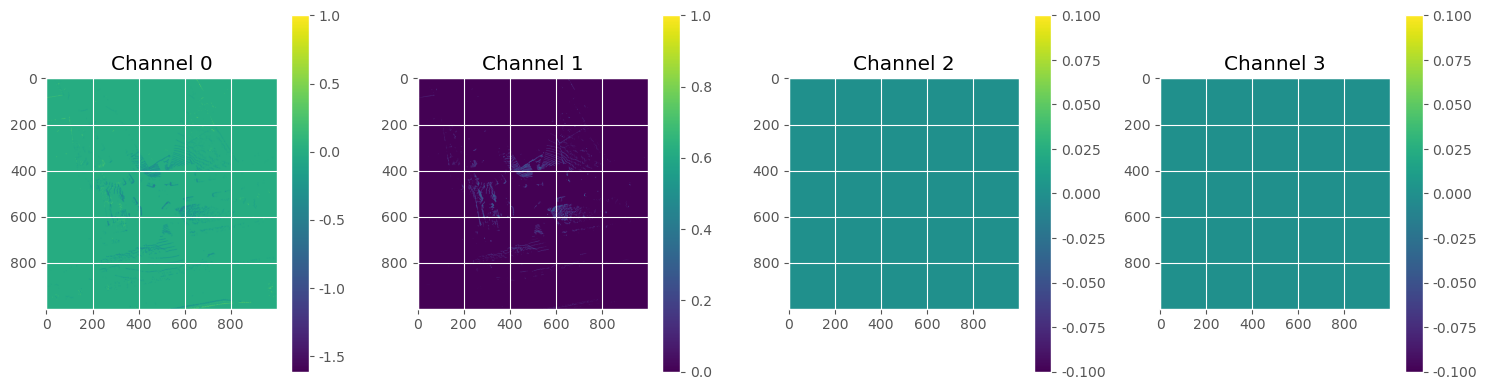

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

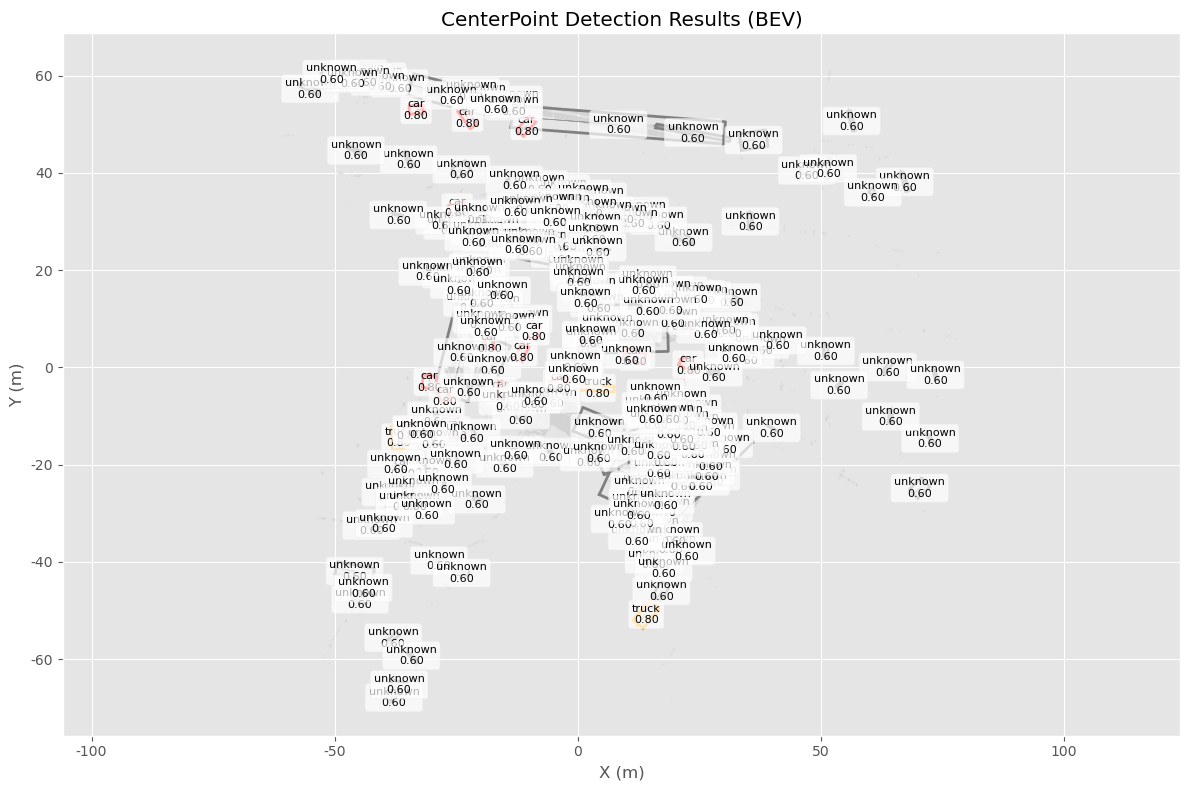

In [9]:
# CenterPoint 모델 정의 (간략화된 버전)
class CenterPointBackbone(nn.Module):
    """CenterPoint 모델의 백본 네트워크"""
    def __init__(self, in_channels=64, out_channels=128):
        super(CenterPointBackbone, self).__init__()
        # ResNet18 기반 백본 네트워크
        self.backbone = resnet18(pretrained=False)
        # 입력 채널 수 변경
        self.backbone.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        # 출력 채널 수 변경
        self.out_conv = nn.Conv2d(512, out_channels, kernel_size=1)
        
    def forward(self, x):
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)
        
        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)
        
        x = self.out_conv(x)
        return x

class CenterPointHead(nn.Module):
    """CenterPoint 모델의 헤드 네트워크"""
    def __init__(self, in_channels=128, num_classes=10):
        super(CenterPointHead, self).__init__()
        self.cls_head = nn.Conv2d(in_channels, num_classes, kernel_size=3, padding=1)
        self.reg_head = nn.Conv2d(in_channels, 8, kernel_size=3, padding=1)  # 8: x, y, z, w, l, h, sin(θ), cos(θ)
        
    def forward(self, x):
        cls_score = self.cls_head(x)
        reg_pred = self.reg_head(x)
        return cls_score, reg_pred

class CenterPoint(nn.Module):
    """CenterPoint 모델"""
    def __init__(self, in_channels=64, out_channels=128, num_classes=10):
        super(CenterPoint, self).__init__()
        self.backbone = CenterPointBackbone(in_channels, out_channels)
        self.head = CenterPointHead(out_channels, num_classes)
        
    def forward(self, x):
        x = self.backbone(x)
        cls_score, reg_pred = self.head(x)
        return cls_score, reg_pred

def create_bev_input(points, voxel_size=(0.1, 0.1, 0.1), range_x=(-50, 50), range_y=(-50, 50), range_z=(-5, 5), num_features=64):
    """
    포인트 클라우드에서 BEV 입력 생성
    
    Args:
        points (numpy.ndarray): 포인트 클라우드 [N, 3+] (x, y, z, ...)
        voxel_size (tuple): 복셀 크기 (x, y, z)
        range_x (tuple): x 좌표 범위
        range_y (tuple): y 좌표 범위
        range_z (tuple): z 좌표 범위
        num_features (int): 특징 수
        
    Returns:
        numpy.ndarray: BEV 입력 [C, H, W]
    """
    # 포인트 클라우드의 범위 계산
    x_min, x_max = range_x
    y_min, y_max = range_y
    z_min, z_max = range_z
    
    # 그리드 크기 계산
    x_size = int((x_max - x_min) / voxel_size[0])
    y_size = int((y_max - y_min) / voxel_size[1])
    z_size = int((z_max - z_min) / voxel_size[2])
    
    # BEV 입력 초기화
    bev_input = np.zeros((num_features, y_size, x_size), dtype=np.float32)
    
    # 각 포인트를 복셀로 변환
    for point in points:
        x, y, z = point[:3]
        
        # 범위 내 포인트만 처리
        if x_min <= x < x_max and y_min <= y < y_max and z_min <= z < z_max:
            # 복셀 인덱스 계산
            x_idx = int((x - x_min) / voxel_size[0])
            y_idx = int((y - y_min) / voxel_size[1])
            z_idx = int((z - z_min) / voxel_size[2])
            
            # 범위 체크
            if 0 <= x_idx < x_size and 0 <= y_idx < y_size and 0 <= z_idx < z_size:
                # 높이 특징 (첫 번째 채널)
                bev_input[0, y_idx, x_idx] = z
                
                # 강도 특징 (두 번째 채널, 강도 정보가 있는 경우)
                if point.shape[0] >= 4:
                    bev_input[1, y_idx, x_idx] = point[3]
                
                # 높이 기반 추가 특징 (채널 2-9)
                if z_idx < 8:
                    bev_input[2 + z_idx, y_idx, x_idx] += 1
    
    # 정규화
    for c in range(bev_input.shape[0]):
        if np.max(bev_input[c]) > 0:
            bev_input[c] /= np.max(bev_input[c])
    
    return bev_input

def simulate_centerpoint_detection(bev_input, points, object_results=None):
    """
    CenterPoint 기반 객체 검출 시뮬레이션 (실제 모델 없이 기존 결과를 약간 변형)
    
    Args:
        bev_input (numpy.ndarray): BEV 입력
        points (numpy.ndarray): 포인트 클라우드
        object_results (list): 이전 객체 검출 결과 (시뮬레이션 기준으로 사용)
        
    Returns:
        list: 객체 검출 결과
    """
    # 이전 결과가 없으면 빈 리스트 반환
    if object_results is None or len(object_results) == 0:
        return []
    
    # 실제로는 모델 추론 단계가 들어가야 함:
    # model = CenterPoint()
    # model.load_state_dict(torch.load('centerpoint_model.pth'))
    # model.eval()
    # with torch.no_grad():
    #     cls_scores, reg_preds = model(torch.FloatTensor(bev_input).unsqueeze(0))
    # 이후 NMS 및 후처리 단계...
    
    # 여기서는 시뮬레이션을 위해 기존 결과에 노이즈 추가
    centerpoint_results = []
    
    for obj in object_results:
        # 원본 결과 복사
        new_obj = obj.copy()
        
        # 위치에 약간의 노이즈 추가
        new_obj['center'] = obj['center'] + np.random.normal(0, 0.2, 3)
        
        # 크기에 약간의 노이즈 추가
        new_obj['dimensions'] = obj['dimensions'] * (1 + np.random.normal(0, 0.1, 3))
        
        # 방향에 약간의 노이즈 추가
        new_obj['yaw'] = obj['yaw'] + np.random.normal(0, 0.1)
        
        # 자신감 약간 높이기 (딥러닝 모델이 더 정확하다고 가정)
        new_obj['confidence'] = min(obj['confidence'] + 0.1, 0.99)
        
        # 결과에 추가
        centerpoint_results.append(new_obj)
    
    return centerpoint_results

# BEV 입력 생성
bev_input = create_bev_input(non_ground_points)

# CenterPoint 기반 객체 검출 시뮬레이션
centerpoint_results = simulate_centerpoint_detection(bev_input, non_ground_points, object_results)

print(f"CenterPoint 검출 객체 수: {len(centerpoint_results)}")
for i, obj in enumerate(centerpoint_results[:3]):  # 처음 3개만 출력
    print(f"객체 {i}: 클래스={obj['class']}, 신뢰도={obj['confidence']:.2f}, 중심점={obj['center']}")

# BEV 입력 시각화
def visualize_bev_input(bev_input):
    """BEV 입력 시각화"""
    # 채널 수가 많으면 첫 몇 개만 시각화
    num_channels = min(bev_input.shape[0], 4)
    
    plt.figure(figsize=(15, 4))
    for i in range(num_channels):
        plt.subplot(1, num_channels, i+1)
        plt.imshow(bev_input[i], cmap='viridis')
        plt.title(f'Channel {i}')
        plt.colorbar()
    
    plt.tight_layout()
    plt.show()

# CenterPoint 객체 검출 결과 시각화
def visualize_centerpoint_results(points, objects):
    """CenterPoint 객체 검출 결과 시각화"""
    plt.figure(figsize=(12, 8))
    
    # 포인트 클라우드 (회색으로 배경처럼 표시)
    plt.scatter(points[:, 0], points[:, 1], c='lightgray', s=0.5, alpha=0.3)
    
    # 클래스별 색상 정의
    class_colors = {
        'car': 'red',
        'truck': 'orange',
        'pedestrian': 'green',
        'cyclist': 'blue',
        'pole': 'purple',
        'unknown': 'gray'
    }
    
    # 각 객체에 대한 바운딩 박스 그리기
    for obj in objects:
        # 객체 클래스 및 중심점
        cls = obj['class']
        center = obj['center']
        
        # 클래스에 따른 색상 선택
        color = class_colors.get(cls, 'gray')
        
        # 회전 각도
        yaw = obj['yaw']
        
        # 바운딩 박스 크기
        length, width, height = obj['dimensions']
        
        # 2D 바운딩 박스 생성 (BEV에서 나타내기 위해 X-Y 평면)
        # 회전을 고려한 코너 계산
        cos_yaw = np.cos(yaw)
        sin_yaw = np.sin(yaw)
        
        # 바운딩 박스의 네 코너 (회전 고려)
        corners = np.array([
            [center[0] + cos_yaw * length / 2 - sin_yaw * width / 2,
             center[1] + sin_yaw * length / 2 + cos_yaw * width / 2],
            [center[0] + cos_yaw * length / 2 + sin_yaw * width / 2,
             center[1] + sin_yaw * length / 2 - cos_yaw * width / 2],
            [center[0] - cos_yaw * length / 2 + sin_yaw * width / 2,
             center[1] - sin_yaw * length / 2 - cos_yaw * width / 2],
            [center[0] - cos_yaw * length / 2 - sin_yaw * width / 2,
             center[1] - sin_yaw * length / 2 + cos_yaw * width / 2],
            [center[0] + cos_yaw * length / 2 - sin_yaw * width / 2,
             center[1] + sin_yaw * length / 2 + cos_yaw * width / 2]  # 첫 번째 포인트 반복하여 폐곡선 생성
        ])
        
        # 바운딩 박스 그리기
        plt.plot(corners[:, 0], corners[:, 1], color=color, linewidth=2)
        
        # 주행 방향 화살표 그리기 (길이 방향)
        direction = np.array([cos_yaw, sin_yaw]) * length / 2
        plt.arrow(center[0], center[1], direction[0], direction[1], 
                  head_width=0.5, head_length=0.7, fc=color, ec=color, alpha=0.7)
        
        # 객체 레이블 표시 (신뢰도 추가)
        plt.text(center[0], center[1], f"{cls}\n{obj['confidence']:.2f}", 
                fontsize=8, ha='center', va='center', 
                bbox=dict(facecolor='white', alpha=0.7, boxstyle='round'))
    
    plt.title('CenterPoint Detection Results (BEV)')
    plt.xlabel('X (m)')
    plt.ylabel('Y (m)')
    plt.axis('equal')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# BEV 입력 시각화
visualize_bev_input(bev_input)

# CenterPoint 객체 검출 결과 시각화
visualize_centerpoint_results(non_ground_points, centerpoint_results)

## 7. YOLO 기반 2D 카메라 이미지 객체 검출

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.


YOLO 검출 객체 수: 4
객체 0: 클래스=bicycle, 신뢰도=0.81, 위치=[884, 50, 995, 117]
객체 1: 클래스=car, 신뢰도=0.61, 위치=[675, 232, 779, 354]
객체 2: 클래스=bus, 신뢰도=0.57, 위치=[245, 121, 383, 236]
객체 3: 클래스=bicycle, 신뢰도=0.70, 위치=[927, 168, 992, 317]


findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.


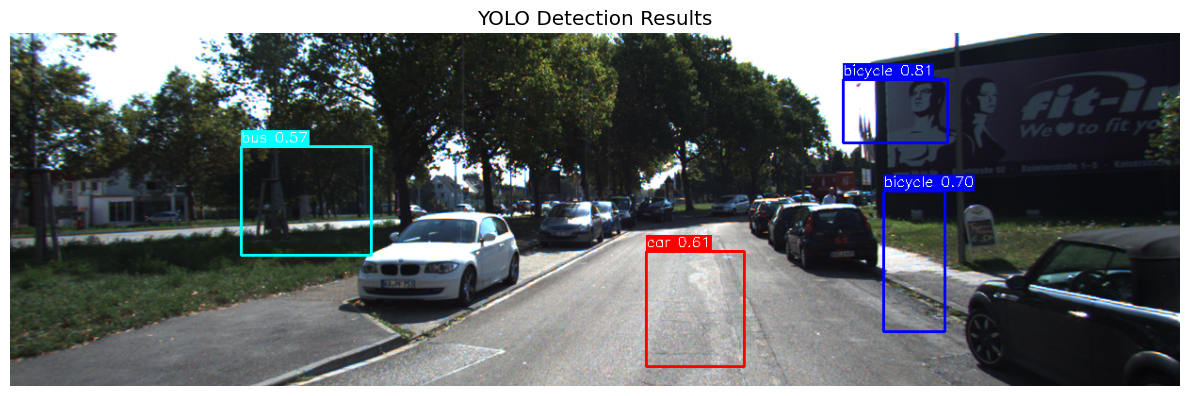

In [10]:
def load_yolo_model():
    """
    YOLO 모델 로드
    
    실제 사용 시에는 YOLOv5/YOLOv8 등 원하는 버전을 로드합니다.
    이 예제에서는 모델 로드를 시뮬레이션합니다.
    
    Returns:
        object: YOLO 모델 객체
    """
    # 실제 구현 시:
    # import torch
    # model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
    # 또는
    # from ultralytics import YOLO
    # model = YOLO('yolov8n.pt')
    
    # 여기서는 간단히 객체만 반환
    class YoloModel:
        def __init__(self):
            self.name = "YOLOv5s"
            self.classes = ['person', 'bicycle', 'car', 'motorcycle', 'bus', 'truck', 'traffic light', 
                           'stop sign', 'bench', 'bird', 'cat', 'dog']
        
        def __call__(self, img):
            """이미지에서 객체 검출 시뮬레이션"""
            height, width = img.shape[:2]
            
            # 시뮬레이션된 검출 결과
            detections = []
            
            # 몇 개의 객체 무작위 생성
            for _ in range(np.random.randint(2, 6)):
                # 무작위 위치 및 크기
                x1 = int(np.random.uniform(0, width - 100))
                y1 = int(np.random.uniform(0, height - 100))
                w = int(np.random.uniform(50, 150))
                h = int(np.random.uniform(50, 150))
                x2 = min(x1 + w, width)
                y2 = min(y1 + h, height)
                
                # 무작위 클래스
                cls_idx = np.random.randint(0, 6)  # 처음 6개 클래스만 사용
                cls_name = self.classes[cls_idx]
                
                # 무작위 신뢰도
                conf = np.random.uniform(0.4, 0.95)
                
                # 검출 결과에 추가
                detections.append({
                    'xyxy': [x1, y1, x2, y2],
                    'confidence': conf,
                    'class': cls_idx,
                    'name': cls_name
                })
            
            return detections
    
    return YoloModel()

def run_yolo_detection(model, image):
    """
    YOLO 모델로 이미지에서 객체 검출
    
    Args:
        model: YOLO 모델
        image (numpy.ndarray): 입력 이미지
        
    Returns:
        list: 검출된 객체 리스트
    """
    # 모델 추론
    detections = model(image)
    
    return detections

def visualize_yolo_detections(image, detections):
    """
    YOLO 검출 결과 시각화
    
    Args:
        image (numpy.ndarray): 입력 이미지
        detections (list): YOLO 검출 결과
    """
    # 이미지 복사
    img_result = image.copy()
    
    # 클래스별 색상 정의
    class_colors = {
        'person': (0, 255, 0),
        'bicycle': (0, 0, 255),
        'car': (255, 0, 0),
        'motorcycle': (255, 0, 255),
        'bus': (0, 255, 255),
        'truck': (255, 255, 0),
        'default': (200, 200, 200)
    }
    
    # 각 검출 결과 그리기
    for det in detections:
        # 바운딩 박스
        x1, y1, x2, y2 = det['xyxy']
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
        
        # 클래스 이름
        cls_name = det['name']
        
        # 신뢰도
        conf = det['confidence']
        
        # 클래스에 따른 색상 선택
        color = class_colors.get(cls_name, class_colors['default'])
        
        # 바운딩 박스 그리기
        cv2.rectangle(img_result, (x1, y1), (x2, y2), color, 2)
        
        # 클래스 이름 및 신뢰도 텍스트
        text = f"{cls_name} {conf:.2f}"
        font_scale = 0.5
        font_thickness = 1
        (text_width, text_height), _ = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, font_scale, font_thickness)
        
        # 텍스트 배경 그리기
        cv2.rectangle(img_result, (x1, y1 - text_height - 5), (x1 + text_width, y1), color, -1)
        
        # 텍스트 그리기
        cv2.putText(img_result, text, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (255, 255, 255), font_thickness)
    
    # 결과 표시
    plt.figure(figsize=(12, 8))
    plt.imshow(img_result)
    plt.title('YOLO Detection Results')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    return img_result

# YOLO 모델 로드
yolo_model = load_yolo_model()

# YOLO 객체 검출 수행
yolo_detections = run_yolo_detection(yolo_model, image)

print(f"YOLO 검출 객체 수: {len(yolo_detections)}")
for i, det in enumerate(yolo_detections):
    print(f"객체 {i}: 클래스={det['name']}, 신뢰도={det['confidence']:.2f}, 위치={det['xyxy']}")

# YOLO 검출 결과 시각화
yolo_result_image = visualize_yolo_detections(image, yolo_detections)

## 8. 3D-2D 객체 융합 및 표현